#한국어 tokenizing
> 솔트룩스 AI Labs NLP파트 김성현 (bananaband657@gmail.com)

##0. Introduction

한국어에서의 다양한 tokenizing 방식을 실습해보겠습니다.   
문장 분리, 형태소 분리는 앞 실습에서 진행하였으므로, 생략하겠습니다.   


*   BPE 분리
*   자소 분리
*   한국어 분석



## 1. BPE 분리

* 아래의 설명은 [Huffon Blog](https://huffon.github.io/2020/07/05/tokenizers/?fbclid=IwAR2_0EB690OcaLjIE3JPUO-iCcdiAwSGxVmmIatIaqlx4Kh7HCyVSTYJA-Qhttps://)를 참고하였습니다.
* BERT는 Byte-pair Encoding (BPE) 방식 기반의 wordPiece 알고리즘을 사용합니다.
* BPE는 언어학적 특징이 상이한 두 언어에 대한 번역을 위해 제안된 tokenizing 방식입니다. ([논문](https://arxiv.org/abs/1508.07909))

* BPE tokenizer를 위해서는 먼저 사전을 학습해야 합니다. (표현상 '학습'이라고 하였으나, 실제로 어떤 가중치가 변하는 학습은 아닙니다.)
* BPE를 수행하기에 앞서, 먼저 기본적인 규칙을 이용해 Pre-tokenizing을 수행합니다.
* 예를 들어, `"경찰청 철창살은 외철창살이고, 검찰청 철창살은 쌍철창살이다."` 라는 문장이 있다고 가정하겠습니다.   
* 위 문장은 다음과 같이 분리될 것입니다.   
`{'경찰청', '철창살은', '외철창살이고', '검찰청', '철창살은', '쌍철창살이다.'}`
   


* BPE를 위한 초기의 기본 사전은 한 음절을 단위로 분리합니다.
* 즉, 위의 어절들은 다음과 같이 분리될 수 있습니다.
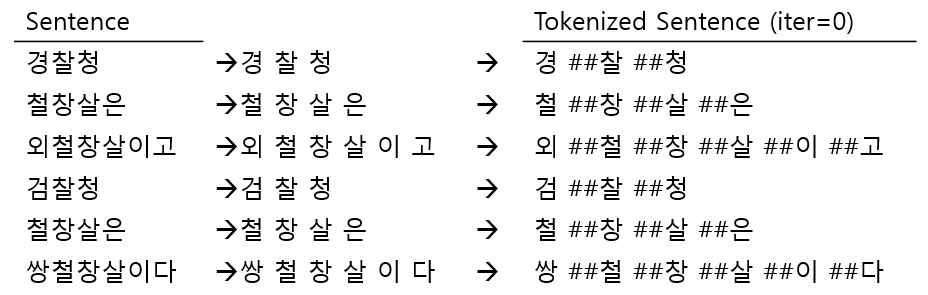

* 음절 단위로 분리한 문장에서 가장 많이 등장한 음절 쌍 후보를 추출합니다.
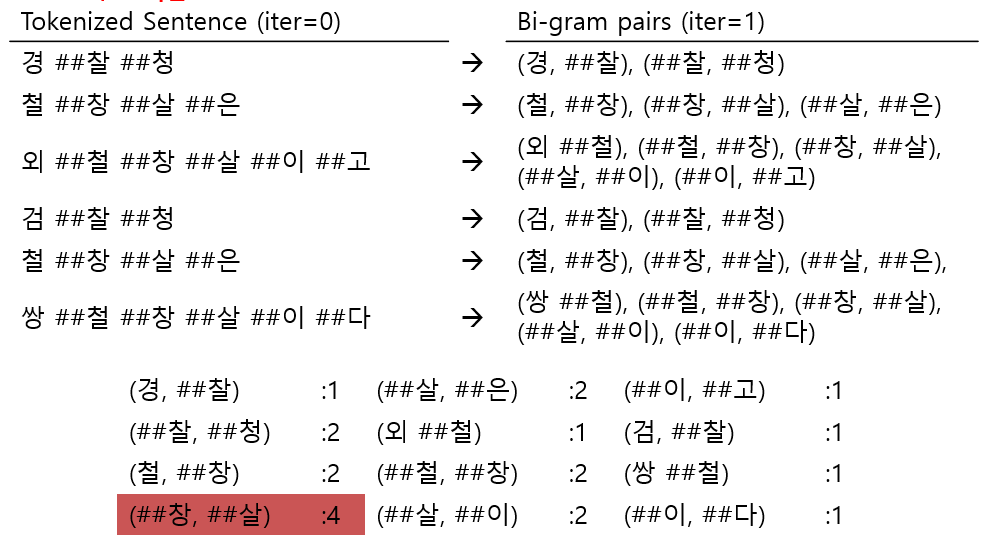

* 빈도수가 제일 높은 음절 쌍을 merge합니다.
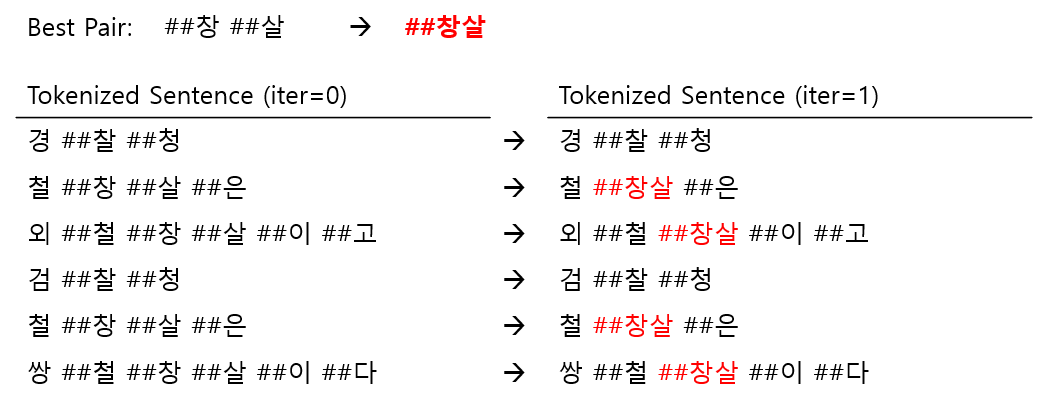

* WordPiece 알고리즘은 위의 merge를 사용자가 지정한 횟수만큼 반복합니다. ([논문](https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/37842.pdf))
* BPE와의 다른 점이 있다면, 코퍼스의 Likelihood를 가장 높이는 쌍을 대상으로 merge를 수행합니다.
* 예를 들어, merge 후보에는 `{'철##창'} `과 ` {'##창살'} `이 있습니다.
* 코퍼스 내에서 한 단어(w)의 등장 확률을 P(w)로 표현할 때,     
`P('##창살') / (P('##창') * P('##살'))` 과 `P('철##창') / (P('철') * P('##창'))` 을 비교하여, 더 높은 값을 가지는 쌍을 merge하게 됩니다.
* 즉, BPE와 달리 WordPiece는 merge가 가능한 후보군들을 서로 비교하며 merge할 가치가 있는 대상만을 merge하게 됩니다.


그럼 실습 데이터를 다운받아, 테스트해보도록 하겠습니다.

In [32]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1CQT4Sear6NKxGiZIW3WpAGkTanO0azrl" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1CQT4Sear6NKxGiZIW3WpAGkTanO0azrl" -o wiki_20190620_small.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    904      0 --:--:-- --:--:-- --:--:--   904
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 40965  100 40965    0     0  63315      0 --:--:-- --:--:-- --:--:-- 63315


Tokenizer 라이브러리를 설치하겠습니다.

In [2]:
!pip install tokenizers

     |████████████████████████████████| 2.9MB 3.4MB/s 


In [37]:
from tokenizers.implementations import SentencePieceBPETokenizer

path = '/content/wiki_20190620_small.txt'
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(files=path, vocab_size=100, min_frequency=5, special_tokens=[
    "<unk>"
])

tokenizer.save_model("/content/", "bpe_tokenizer")

['/content/bpe_tokenizer-vocab.json', '/content/bpe_tokenizer-merges.txt']

In [39]:
vocab_file_path = '/content/bpe_tokenizer-vocab.json'
merge_file_path = '/content/bpe_tokenizer-merges.txt'

tokenizer = SentencePieceBPETokenizer(vocab_file_path, merge_file_path)

def tokenizing(text):
    return tokenizer.encode(text).tokens

result = tokenizing("이순신은 조선 중기의 무신이다.")
print(result)

['▁', '이', '순', '신', '은', '▁', '조', '선', '▁', '중', '기', '의', '▁', '무', '신', '이', '다', '.']


## 2. 자소 분리

In [40]:
!pip install hgtk

  Created wheel for hgtk: filename=hgtk-0.1.3-py2.py3-none-any.whl size=6688 sha256=6925f732a7c89d3b2c6aeff65dc0cc18eac4defa26648ab54ebf7e1770d8a0ba
  Stored in directory: /root/.cache/pip/wheels/73/72/06/6065a57fe68264f35d7e52e37f56831eb3e9ec75656880de20
Successfully built hgtk


In [42]:
import hgtk
hgtk.text.decompose('학교종이 땡땡땡! hello world 1234567890 ㅋㅋ!')

'ㅎㅏㄱᴥㄱㅛᴥㅈㅗㅇᴥㅇㅣᴥ ㄸㅐㅇᴥㄸㅐㅇᴥㄸㅐㅇᴥ! hello world 1234567890 ㅋᴥㅋᴥ!'

In [43]:
hgtk.text.compose('ㅎㅏㄱᴥㄱㅛᴥㅈㅗㅇᴥㅇㅣᴥ ㄸㅐㅇᴥㄸㅐㅇᴥㄸㅐㅇᴥ! hello world 1234567890 ㅋᴥㅋᴥ!')

'학교종이 땡땡땡! hello world 1234567890 ㅋㅋ!'

## 3. 한국어 분석 실습

In [44]:
hgtk.checker.is_hangul('한글입니다')

True

In [45]:
hgtk.checker.is_hangul('no한글입니다')

False

In [46]:
hgtk.checker.is_hanja('大韓民國')

True

In [47]:
hgtk.checker.is_hanja('大한민국')

False

In [48]:
hgtk.checker.has_batchim('한')

True

In [51]:
hgtk.checker.has_batchim('하')

False

In [52]:
print(hgtk.josa.attach('하늘', hgtk.josa.EUN_NEUN))
print(hgtk.josa.attach('바다', hgtk.josa.EUN_NEUN))
print(hgtk.josa.attach('하늘', hgtk.josa.I_GA))
print(hgtk.josa.attach('바다', hgtk.josa.I_GA))
print(hgtk.josa.attach('하늘', hgtk.josa.EUL_REUL))
print(hgtk.josa.attach('바다', hgtk.josa.EUL_REUL))
print(hgtk.josa.attach('하늘', hgtk.josa.GWA_WA))
print(hgtk.josa.attach('바다', hgtk.josa.GWA_WA))
print(hgtk.josa.attach('하늘', hgtk.josa.IDA_DA))
print(hgtk.josa.attach('바다', hgtk.josa.IDA_DA))
print(hgtk.josa.attach('하늘', hgtk.josa.EURO_RO))
print(hgtk.josa.attach('바다', hgtk.josa.EURO_RO))
print(hgtk.josa.attach('태양', hgtk.josa.EURO_RO))
print(hgtk.josa.attach('방어', hgtk.josa.RYUL_YUL))
print(hgtk.josa.attach('공격', hgtk.josa.RYUL_YUL))
print(hgtk.josa.attach('반환', hgtk.josa.RYUL_YUL))

하늘은
바다는
하늘이
바다가
하늘을
바다를
하늘과
바다와
하늘이다
바다다
하늘로
바다로
태양으로
방어율
공격률
반환율
